In [ ]:
!pip install scikit-image opencv-python noise2void


ERROR: Could not find a version that satisfies the requirement noise2void (from versions: none)
ERROR: No matching distribution found for noise2void


In [ ]:
!pip install scikit-image opencv-python


In [ ]:
!wget https://download.samplelib.com/mp4/sample-5s.mp4 -O sample_video.mp4


--2025-04-29 06:14:21--  https://download.samplelib.com/mp4/sample-5s.mp4
Resolving download.samplelib.com (download.samplelib.com)... 188.227.59.182
Connecting to download.samplelib.com (download.samplelib.com)|188.227.59.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2848208 (2.7M) [video/mp4]
Saving to: ‘sample_video.mp4’

sample_video.mp4    100%[===================>]   2.72M  5.63MB/s    in 0.5s    

2025-04-29 06:14:21 (5.63 MB/s) - ‘sample_video.mp4’ saved [2848208/2848208]



In [ ]:
import cv2
import os

# Create a directory to save frames
os.makedirs('frames', exist_ok=True)

cap = cv2.VideoCapture('sample_video.mp4')

frame_number = 0
while True:
    success, frame = cap.read()
    if not success:
        break
    cv2.imwrite(f"frames/frame_{frame_number}.jpg", frame)
    frame_number += 1

cap.release()
print(f"Extracted {frame_number} frames.")


Extracted 171 frames.


In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.0 MB/s eta 0:00:00


Median Filter -> PSNR: 26.171247604945343, SSIM: 0.8832004973116577, MSE: 157.02022681970163
Wavelet Filter -> PSNR: 48.863706564799784, SSIM: 0.9975251552060188, MSE: 0.844714023919753


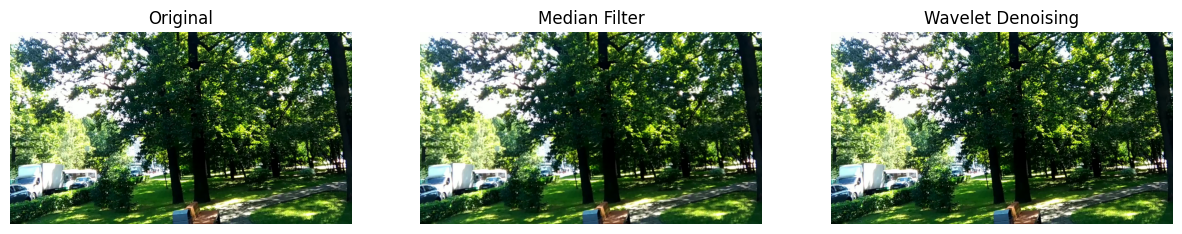

In [ ]:
from skimage import restoration, metrics
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read one noisy frame
img = cv2.imread('frames/frame_0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Median filter
median_denoised = cv2.medianBlur(img, 5)

# Wavelet filter
wavelet_denoised = restoration.denoise_wavelet(img, channel_axis=-1, rescale_sigma=True)
wavelet_denoised = (wavelet_denoised * 255).astype(np.uint8)

# Metrics function
def calculate_metrics(original, denoised):
    psnr = metrics.peak_signal_noise_ratio(original, denoised)
    ssim = metrics.structural_similarity(original, denoised, channel_axis=-1)
    mse = metrics.mean_squared_error(original, denoised)
    return psnr, ssim, mse

# Calculate Metrics
psnr_median, ssim_median, mse_median = calculate_metrics(img, median_denoised)
psnr_wavelet, ssim_wavelet, mse_wavelet = calculate_metrics(img, wavelet_denoised)

print(f"Median Filter -> PSNR: {psnr_median}, SSIM: {ssim_median}, MSE: {mse_median}")
print(f"Wavelet Filter -> PSNR: {psnr_wavelet}, SSIM: {ssim_wavelet}, MSE: {mse_wavelet}")

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(img)
axs[0].set_title('Original')
axs[1].imshow(median_denoised)
axs[1].set_title('Median Filter')
axs[2].imshow(wavelet_denoised)
axs[2].set_title('Wavelet Denoising')
for ax in axs:
    ax.axis('off')
plt.show()



Median Filter Results:
PSNR: 24.734689823370037
SSIM: 0.751966966304516
MSE: 0.003361483761785195

Wavelet Denoising Results:
PSNR: 26.919260526004607
SSIM: 0.7718638143941948
MSE: 0.0020327030901926366

Non-Local Means Results:
PSNR: 26.369520404216612
SSIM: 0.7613256087027555
MSE: 0.002307001939208196


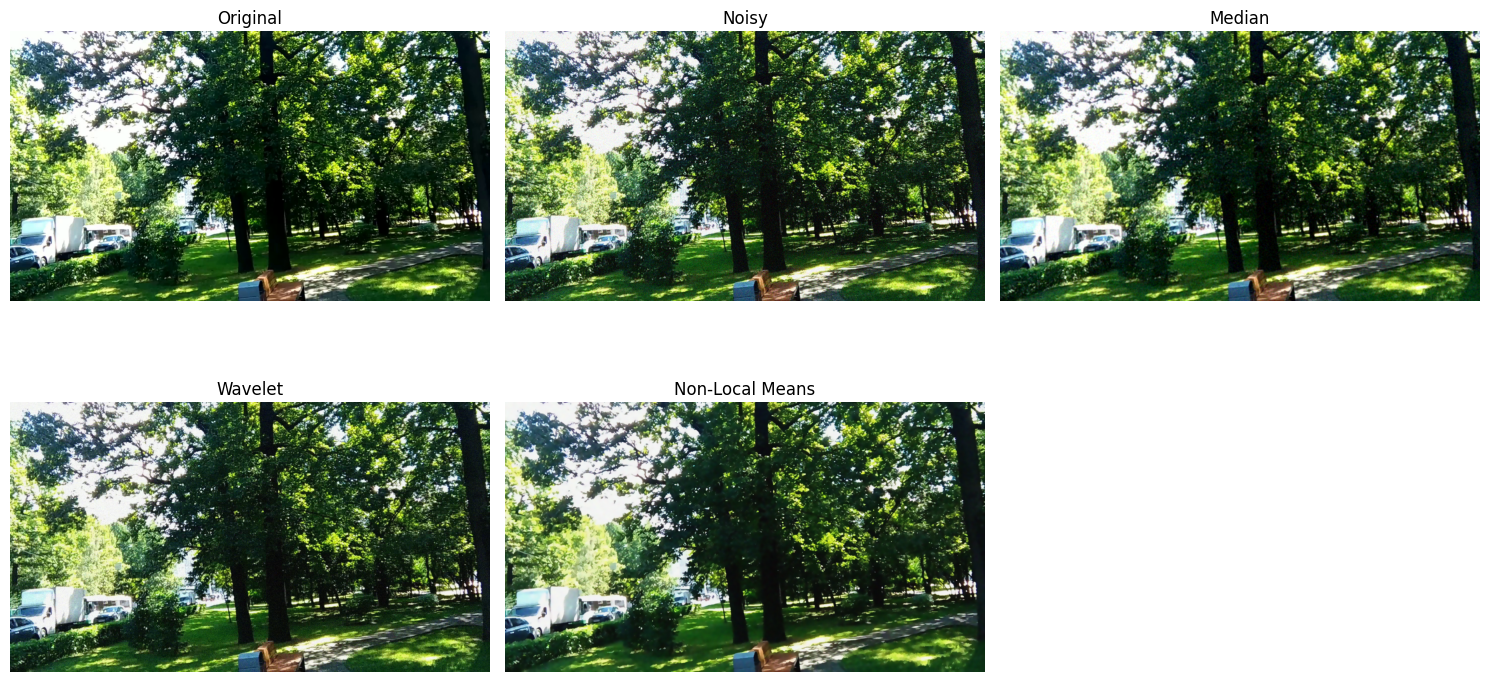

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, img_as_ubyte
from skimage.restoration import denoise_wavelet, denoise_nl_means, estimate_sigma
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim, mean_squared_error as mse
import os

# Load image
img_path = 'frames/frame_0.jpg'  # Replace this with your image file
if not os.path.exists(img_path):
    raise FileNotFoundError("Image not found. Please check the path.")

original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
original = img_as_float(original)

# Add synthetic Gaussian noise
noisy = random_noise(original, var=0.01)

# 1. Median Filter (apply on grayscale for simplicity) applies a median filter with 3 kernal
noisy_uint8 = img_as_ubyte(noisy)
median = cv2.medianBlur(noisy_uint8, 5)
median = img_as_float(median)

# 2. Wavelet Denoising- works in frequency domanin
wavelet = denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft')

# 3. Non-Local Means (used as alternative to Noise2Void)
sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))
nl_means = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=True,
                             patch_size=5, patch_distance=6, channel_axis=-1)

# Metrics
def evaluate(img_name, denoised):
    print(f"\n{img_name} Results:")
    print("PSNR:", psnr(original, denoised)) #higher is better
    print("SSIM:", ssim(original, denoised, channel_axis=-1, data_range=1.0)) #closer to 1
    print("MSE:", mse(original, denoised)) #lower is better

evaluate("Median Filter", median)
evaluate("Wavelet Denoising", wavelet)
evaluate("Non-Local Means", nl_means)

# Plot results
titles = ['Original', 'Noisy', 'Median', 'Wavelet', 'Non-Local Means']
images = [original, noisy, median, wavelet, nl_means]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
#PSNR (Peak Signal-to-Noise Ratio): Higher = better quality.

#SSIM (Structural Similarity Index): Closer to 1 = more similar to original.

#MSE (Mean Squared Error): Lower = less error from original.



In [ ]:
frames = []
cap = cv2.VideoCapture('sample_video.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break
    edges = cv2.Canny(frame, 100, 200)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Make it 3 channel
    frames.append(edges_colored)

cap.release()

# Save processed frames as video
height, width, layers = frames[0].shape
out = cv2.VideoWriter('canny_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

for frame in frames:
    out.write(frame)

out.release()
print("New Canny edge video saved as 'canny_video.avi'.")


New Canny edge video saved as 'canny_video.avi'.


In [ ]:
cap = cv2.VideoCapture('sample_video.mp4')
frames_adaptive = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    adaptive_colored = cv2.cvtColor(adaptive, cv2.COLOR_GRAY2BGR)
    frames_adaptive.append(adaptive_colored)

cap.release()

# Save video
height, width, _ = frames_adaptive[0].shape
out = cv2.VideoWriter('adaptive_thresholding.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

for frame in frames_adaptive:
    out.write(frame)

out.release()
print("Adaptive Thresholding video saved.")


Adaptive Thresholding video saved.


In [ ]:
cap = cv2.VideoCapture('sample_video.mp4')
frames_gaussian = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    frames_gaussian.append(blurred)

cap.release()

# Save video
out = cv2.VideoWriter('gaussian_smoothing.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

for frame in frames_gaussian:
    out.write(frame)

out.release()
print("Gaussian Smoothing video saved.")


Gaussian Smoothing video saved.


In [ ]:
import cv2

cap = cv2.VideoCapture('sample_video.mp4')
frames_bitwise_not = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Apply bitwise NOT to the frame
    frame_bitwise_not = cv2.bitwise_not(frame)
    frames_bitwise_not.append(frame_bitwise_not)

cap.release()

# Get the width and height of the video
height, width, _ = frames_bitwise_not[0].shape

# Save video with bitwise NOT applied
out = cv2.VideoWriter('bitwise_not_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

for frame in frames_bitwise_not:
    out.write(frame)

out.release()
print("Bitwise NOT video saved.")


Bitwise NOT video saved.


In [ ]:
import cv2
import numpy as np

# Video processing (Gaussian Smoothing)
cap = cv2.VideoCapture('sample_video.mp4')
frames_gaussian = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    frames_gaussian.append(blurred)
cap.release()

# Video processing (Bitwise NOT)
cap = cv2.VideoCapture('sample_video.mp4')
frames_bitwise_not = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_bitwise_not = cv2.bitwise_not(frame)
    frames_bitwise_not.append(frame_bitwise_not)
cap.release()

# Video processing (Adaptive Thresholding)
cap = cv2.VideoCapture('sample_video.mp4')
frames_adaptive = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    adaptive_colored = cv2.cvtColor(adaptive, cv2.COLOR_GRAY2BGR)
    frames_adaptive.append(adaptive_colored)
cap.release()

# Video processing (Canny Edge Detection)
cap = cv2.VideoCapture('sample_video.mp4')
frames_canny = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    edges = cv2.Canny(frame, 100, 200)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    frames_canny.append(edges_colored)
cap.release()

# Resize frames for collage
frame1 = cv2.resize(frames_gaussian[0], (300, 300))
frame2 = cv2.resize(frames_bitwise_not[0], (300, 300))
frame3 = cv2.resize(frames_adaptive[0], (300, 300))
frame4 = cv2.resize(frames_canny[0], (300, 300))

# Stack frames to create collage
top = np.hstack((frame1, frame2))
bottom = np.hstack((frame3, frame4))
collage = np.vstack((top, bottom))

# Save the collage
cv2.imwrite('collage.jpg', collage)
print("Collage saved as 'collage.jpg'")

# Save the videos
height, width, _ = frames_gaussian[0].shape
out_gaussian = cv2.VideoWriter('gaussian_smoothing.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))
out_bitwise = cv2.VideoWriter('bitwise_not_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))
out_adaptive = cv2.VideoWriter('adaptive_thresholding.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))
out_canny = cv2.VideoWriter('canny_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

# Save each processed video
for i in range(len(frames_gaussian)):
    out_gaussian.write(frames_gaussian[i])
    out_bitwise.write(frames_bitwise_not[i])
    out_adaptive.write(frames_adaptive[i])
    out_canny.write(frames_canny[i])

out_gaussian.release()
out_bitwise.release()
out_adaptive.release()
out_canny.release()

print("Videos saved: 'gaussian_smoothing.avi', 'bitwise_not_video.avi', 'adaptive_thresholding.avi', 'canny_video.avi'")


Collage saved as 'collage.jpg'
Videos saved: 'gaussian_smoothing.avi', 'bitwise_not_video.avi', 'adaptive_thresholding.avi', 'canny_video.avi'
